Symbolic execution
1. Parse the code into a DAG
2. Collect all the conditions in every path
3. Solve it using Z3

In [111]:
import dis
import random
from z3 import z3
from collections import deque
import copy
from dis import Instruction
from typing import List
import math
from inspect import signature
from z3 import CheckSatResult
from collections import deque
from graphviz import Digraph
def deepCopy(s: z3.Solver,operandStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref):
    solverCopy = z3.Solver()
    solverCopy.add(s.assertions())
    operandStackCopy = deque([])
    for i in range(len(operandStack)):
        operandStackCopy.append(operandStack[i])
    # copy.deepcopy(operandStack)

    mapVariableToLatestVersionIdCopy = {}
    for (k,v) in mapVariableToLatestVersionId.items():
        mapVariableToLatestVersionIdCopy[k] = v
    # copy.deepcopy(mapVariableToLatestVersionId)
    mapVariableToLatestZ3RefCopy = {}
    for (k,v) in mapVariableToLatestZ3Ref.items():
        mapVariableToLatestZ3RefCopy[k] = v
    # copy.deepcopy(mapVariableToLatestZ3Ref)
    return (solverCopy,operandStackCopy,mapVariableToLatestVersionIdCopy,mapVariableToLatestZ3RefCopy)

def createOperationResult(variableType_: z3.ExprRef,
                                isInt: bool,
                                variableName: str,
                                mapVariableToLatestVersionId: map
                                ):
    if variableName in mapVariableToLatestVersionId:
        #Create a new version
        mapVariableToLatestVersionId[variableName] += 1
    else:
        #First version
        mapVariableToLatestVersionId[variableName] = 1
    match variableType_:
        case z3.ArithRef:
            if isInt:
                res = z3.Int(variableName+"@"+str(mapVariableToLatestVersionId[variableName]))
            else:
                res = z3.Real(variableName+"@"+str(mapVariableToLatestVersionId[variableName]))
        case z3.BoolRef:
            res = z3.Bool(variableName+"@"+str(mapVariableToLatestVersionId[variableName]))
    return res


def handleBinaryInstruction(operationName: str,
                            variableName: str,
                            operandsStack: deque,
                            mapVariableToLatestVersionId: map,
                            mapVariableNameToLatestZ3Ref: map,
                            solver_: z3.Solver):
    operand1 = operandsStack.pop()
    operand2 = operandsStack.pop()
    if variableName is None:#Variable name may not be available
        variableName = "Temp"
    #z3 supports Integers, Reals and Bools
    match operationName:
        case "BINARY_ADD":
            temp = operand1 + operand2
            isInt = False
            if type(temp) == z3.ArithRef:
                temp = operand1 + operand2
                isInt = temp.is_int()
            res = createOperationResult(type(temp),isInt,variableName,mapVariableToLatestVersionId)
            solver_.add(res == operand1 + operand2)
        case "BINARY_SUBTRACT":
            temp = operand1 - operand2
            isInt = False
            if type(temp) == z3.ArithRef:
                isInt = temp.is_int()
            res = createOperationResult(type(temp),isInt,variableName,mapVariableToLatestVersionId)
            solver_.add(res == operand1 - operand2)
        case "BINARY_MULTIPLY":
            temp = operand1 * operand2
            isInt = False
            if type(temp) == z3.ArithRef:
                isInt = temp.is_int()
            res = createOperationResult(type(temp),isInt,variableName,mapVariableToLatestVersionId)
            solver_.add(res == operand1 * operand2)
        case "==":
            res = createOperationResult(z3.BoolRef,False,variableName,mapVariableToLatestVersionId)
            solver_.add(res == (operand1 == operand2))
        case "<":
            res = createOperationResult(z3.BoolRef,False,variableName,mapVariableToLatestVersionId)
            solver_.add(res == (operand1 < operand2))
        case ">":
            res = createOperationResult(z3.BoolRef,False,variableName,mapVariableToLatestVersionId)
            solver_.add(res == (operand1 > operand2))
        case ">=":
            res = createOperationResult(z3.BoolRef,False,variableName,mapVariableToLatestVersionId)
            solver_.add(res == (operand1 >= operand2))
        case "<=":
            res = createOperationResult(z3.BoolRef,False,variableName,mapVariableToLatestVersionId)
            solver_.add(res == (operand1 <= operand2))
        case _:
            raise Exception("Operation " + str(operationName) + " is not handled")
        # Need to add DIVISION, COMPARE operations
    mapVariableNameToLatestZ3Ref[variableName] = res
    operandsStack.append(res)
    return


def handleAssignment(       variableName: str,
                            operandsStack: deque,
                            mapVariableToLatestVersionId: map,
                            mapVariableNameToLatestZ3Ref: map,
                            solver_: z3.Solver):
    if len(operandsStack)==0:
        raise Exception("Operand stack is empty, did you push all the loads ?")
    tempVariable = operandsStack.pop()
    if issubclass(type(tempVariable),z3.ExprRef):
        isInt = False
        if type(tempVariable) == z3.ArithRef and tempVariable.is_int():
            isInt = True
        res = createOperationResult(type(tempVariable),isInt,variableName,mapVariableToLatestVersionId)
    else:
        if type(tempVariable) == int:
            res = createOperationResult(z3.ArithRef,True,variableName,mapVariableToLatestVersionId)
        elif type(tempVariable) == float:
            res = createOperationResult(z3.ArithRef,False,variableName,mapVariableToLatestVersionId)
        elif type(tempVariable) == bool:
            res = createOperationResult(z3.BoolRef,False,variableName,mapVariableToLatestVersionId)
        else:
            raise Exception("Unhandled type:"+ type(tempVariable))
    # operandsStack.append(res)
    mapVariableNameToLatestZ3Ref[variableName] = res
    solver_.add(res == tempVariable)


def constructArguments(fn):
    mapVariableToLatestVersionId = {}
    mapVariableToLatestZ3Ref = {}
    params = signature(fn).parameters
    args = []
    for var in params.keys():
        variableName = params[var].name
        variableType = params[var].annotation.__name__
        args.append((variableName,variableType))
        if str(variableType) == "int" or str(variableType) == "float":
            type_ = z3.ArithRef
            isInt_ = str(variableType)=="int"
        elif str(variableType)=="bool":
            type_ = z3.BoolRef
            isInt_ = False
        else:
            raise Exception("Unhandled type" + str(param.annotation) + " did you forget to mention the type of the arguments in the function signature ?  Ex: def func1(a:int,b:int):")
        res = createOperationResult(type_,isInt_,str(variableName),mapVariableToLatestVersionId)
        mapVariableToLatestZ3Ref[str(variableName)]=res
        # print("$$$",mapVariableToLatestVersionId,mapVariableToLatestZ3Ref,"$$$")
    return mapVariableToLatestVersionId, mapVariableToLatestZ3Ref,args



class Node:
    def __init__(self, nodeId_,instructions_: List[Instruction],children_: List['Node']=None):
        if children_ is None:
            children_ = []
        self.children = children_
        self.nodeId = nodeId_
        self.instructions = instructions_
def DFS(currentNode:Node,operandsStack:deque,
        mapVariableToLatestVersionId,
        mapVariableToLatestZ3Ref,
        s_: z3.Solver,models,parent):
    # print("Parent:"+str(parent),"CurrentNode"+str(currentNode.nodeId),"Lafoot",s_,operandsStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref)
    # print("Node:"+str(currentNode.nodeId))
    for instr_ in currentNode.instructions:
        match str(instr_.opname):
            case "LOAD_FAST":
                if str(instr_.argval) in mapVariableToLatestVersionId:
                    # print("$$$",str(instr_.argval),mapVariableToLatestZ3Ref[str(instr_.argval)],"$$$")
                    operandsStack.append(mapVariableToLatestZ3Ref[str(instr_.argval)])
                else:
                    raise Exception(instr_.argval + " not seen earlier")
            case "LOAD_CONST":
                operandsStack.append(instr_.argval)
            case "STORE_FAST":
                variableName = str(instr_.argval)
                handleAssignment(variableName,operandsStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref,s_)
            case "BINARY_MULTIPLY" | "BINARY_SUBTRACT" | "BINARY_ADD" :
                handleBinaryInstruction(str(instr_.opname),None,operandsStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref,s_)
            case "RETURN_VALUE":
                #Generate test case
                if str(s_.check())=="sat":
                    # print(s_.assertions())
                    model = s_.model()
                    models.append(model)
            case "COMPARE_OP":
                handleBinaryInstruction(str(instr_.argval),None,operandsStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref,s_)
            case "POP_JUMP_IF_FALSE" | "POP_JUMP_IF_TRUE":
                #assert there must be two children
                # Pop the top element of the operand stack
                # deepcopy the solver,operand stack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref once for each child
                # Case 1: add an entry that the top element is False into the solver, DFS to the child which has the jump offset
                # Case 2: add an entry to the solver that the top element is True, DFS to the child
                assert len(currentNode.children) == 2, f"Current node {currentNode} doesn't have 2 children"
                boolElement = operandsStack.pop()
                jumpIfFalse = "FALSE" in str(instr_.opname)
                # print("CHILDREN!!!",currentNode.children)
                for child in currentNode.children:
                    s_Copy,operandsStackCopy,mapVariableToLatestVersionIdCopy,mapVariableToLatestZ3RefCopy = deepCopy(s_,operandsStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref)
                    # print("CHILD!!!!")
                    if str(child.nodeId) == str(instr_.argval): # JUMP
                        if jumpIfFalse:
                            s_Copy.add(boolElement == False)
                        else:
                            s_Copy.add(boolElement == True)
                    else:
                        if jumpIfFalse:
                            s_Copy.add(boolElement == True)
                        else:
                            s_Copy.add(boolElement == False)
                    DFS(child,operandsStackCopy,mapVariableToLatestVersionIdCopy,mapVariableToLatestZ3RefCopy,s_Copy,models,currentNode.nodeId)
                    # print(child.nodeId)
                    # print("CHILD!!!!")
            case _:
                raise Exception("Unhandled instruction:"+str(instr_))


def generateTestCases(fn):
    s =  z3.Solver()
    (mapVariableToLatestVersionId,mapVariableToLatestZ3Ref,args) = constructArguments(fn)

    # Dividing the bytecode into blocks of instructions
    # Each block is uniquely identified by the line offset of its starting instructions in byte code
    # Each block can have more than one parent and maximum two children
    edges = []
    nodes = []
    prevInstructionIsJump = False
    byteCode = dis.Bytecode(fn)
    print(byteCode)
    for instr in byteCode:
        # Adding edges
        if prevInstructionIsJump:
            edges.append((nodes[-1],instr.offset))
        if "JUMP" in instr.opname:
            edges.append((nodes[-1],int(instr.argval)))
        # Adding nodes
        if instr.is_jump_target:
            nodes.append(instr.offset)
        if prevInstructionIsJump:
            nodes.append(instr.offset)
        if instr.offset == 0:
            nodes.append(instr.offset)
        # print(instr.offset,instr.opname,instr.arg,instr.argval,instr.is_jump_target)
        if "JUMP" in instr.opname:
            prevInstructionIsJump = True
        else:
            prevInstructionIsJump = False

    nodes = list(set(nodes))
    nodes.sort()
    edges = list(set(edges))
    # print("edges",edges)
    # Constructing a graph where each node/block will include details like
    # 1. What are the instructions being used
    # 2. What are its child nodes

    nodeIdToGraphObjectMapping = {}
    for i in range(len(nodes)):
        start = nodes[i]
        # If i is the last node
        if i+1==len(nodes):
            end = math.inf
        else:
            end = nodes[i+1]
        instructions = []
        nodeId = start
        for instr in byteCode:
            if start <= instr.offset < end:
                instructions.append(instr)
        nodeIdToGraphObjectMapping[nodeId] = Node(nodeId,instructions)

    for (nodeId1,nodeId2) in edges:
        nodeIdToGraphObjectMapping[nodeId1].children.append(nodeIdToGraphObjectMapping[nodeId2])

    root = nodeIdToGraphObjectMapping[0]


    gra = Digraph()
    for (nodeId,node) in nodeIdToGraphObjectMapping.items():
        gra.node(str(nodeId),str(",".join([str(instr.offset) for instr in node.instructions])))
    for (nodeId,node) in nodeIdToGraphObjectMapping.items():
        for child in node.children:
            gra.edge(str(nodeId),str(child.nodeId))
    operandsStack = deque([])
    models = []
    DFS(root,operandsStack,mapVariableToLatestVersionId,mapVariableToLatestZ3Ref,s,models,"-1")
    # print(models)
    results = []
    for model in models:
        result = []
        for (variableName,variableType) in args:
            isPresent = False
            for var in model:
                if str(var) == variableName+"@1": #First version of the argument
                   result.append((variableName,str(model[var])))
                   isPresent = True
            if not isPresent:
                if str(variableType) == "int":
                    result.append((variableName,str(random.randint(1,9))))
                elif str(variableType) == "float":
                    result.append((variableName,str(round(random.random(), 2))))
                elif str(variableType) == "bool":
                    result.append((variableName,str(bool(random.getrandbits(1)))))

        results.append(result)


    return gra,byteCode,models,results

In [109]:
def func1(a:int,b:int):
    a = a * 1
    b = b + 4
    a = a + 4
    c = a * a
    return a

def func2(a:int,b:float):
    if a == 1 and b==2.3:
        b = 2
        return 233
    return 333

def func3(a:int,b:int):
    if a == 1 and b==2:
        b = 2
        return 233
    elif b==3:
        b = 4
        return
    else:
        a = 1
    return 333

def func4(a:int,b:int,c:bool):
    if a==3 or c:
        if b==4:
            return
        else:
            return
    elif a==2 and b==4:
        return
    else:
        return

In [110]:
dis.dis(func2)
(g,_,models,r) = generateTestCases(func2)
r

  9           0 LOAD_FAST                0 (a)
              2 LOAD_CONST               1 (1)
              4 COMPARE_OP               2 (==)
              6 POP_JUMP_IF_FALSE       12 (to 24)
              8 LOAD_FAST                1 (b)
             10 LOAD_CONST               2 (2.3)
             12 COMPARE_OP               2 (==)
             14 POP_JUMP_IF_FALSE       12 (to 24)

 10          16 LOAD_CONST               3 (2)
             18 STORE_FAST               1 (b)

 11          20 LOAD_CONST               4 (233)
             22 RETURN_VALUE

 12     >>   24 LOAD_CONST               5 (333)
             26 RETURN_VALUE
Bytecode(<function func2 at 0x122cf0dc0>)


[[('a', '2'), ('b', '0.55')],
 [('a', '1'), ('b', '33/10')],
 [('a', '1'), ('b', '23/10')]]

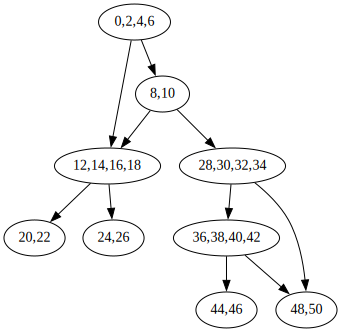

In [105]:
g